In [61]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imutils.perspective import four_point_transform
from PIL import Image, ImageOps
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [104]:
from keras.models import load_model

### def : scan_document, used to scan the photos taken using a cellphone camera. The function output consists on PIL image of the form in fixed dimension

In [2]:
def scan_document(path):

    height = 1000
    width = 600
    green = (0, 255, 0)
    # Insert path of photo
    image = cv2.imread(path)
    image = cv2.resize(image, (width, height))
    orig_image = image.copy()
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert the image to gray scale
    blur = cv2.GaussianBlur(image, (5, 5), 0) # Add Gaussian blur
    edged = cv2.Canny(blur, 75, 200)
    # Show the image and the edges
    #cv2.imshow('Original image:', image)
    #cv2.imshow('Edged:', edged)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # Show the image and all the contours
    #cv2.imshow("Image", image)
    #cv2.drawContours(image, contours, -1, green, 3)
    #cv2.imshow("All contours", image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    # go through each contour
    for contour in contours:
        # we approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
        # if we found a countour with 4 points we break the for loop
        # (we can assume that we have found our document)
        if len(approx) == 4:
            doc_cnts = approx
            break

    # We draw the contours on the original image not the modified one
    #cv2.drawContours(orig_image, [doc_cnts], -1, green, 3)
    #cv2.imshow("Contours of the document", orig_image)
    # apply warp perspective to get the top-down view
    warped = four_point_transform(orig_image, doc_cnts.reshape(4, 2))
    # convert the warped image to grayscale
    #warped = cv2.cvtColor(warped, cv2.IMREAD_UNCHANGED)
    ## Resize Image to desired output dimension this value has to be monitored given the dimensions of the implemented form E14
    re = cv2.resize(warped,(300,1100))
    print("Image dimension",re.shape)
    #cv2.imshow("Scanned", cv2.resize(warped, (300, 1100)))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #Convert array to PIL Image
    img = Image.fromarray(re)
    #Uncomment this line to save the output scanned image
    #img.save("scanned/scan_1.jpeg")
    print("Photo was scanned :)")
    return img

## def : extract sector, the function extracts the three main regions of interest of the form.

In [3]:
def extract_sectors(img):
    #img= Image.open(path)
    ##Coordinates of sector 1
    l_1,t_1,r_1,b_1=188,375,252,525
    coord_1 = (l_1, t_1, r_1, b_1)
    sec_1 = img.crop(coord_1)
    #Coordinates of sector 2
    l_2,t_2,r_2,b_2 =40,328,250,350
    coord_2 = (l_2, t_2, r_2, b_2)
    sec_2 = img.crop(coord_2)
    #Coordinates of sector 3 : QR code
    l_3,t_3,r_3,b_3 =35,107,114,182
    coord_3 = (l_3, t_3, r_3, b_3)
    sec_3 = img.crop(coord_3)
    
    secs = [sec_1,sec_2,sec_3]


    return secs

## def: qr_decode , detect and decode QR code

In [4]:
## For the moment it is better to decode the QR code from the original capture instead of the scanned image
## This aspect has to be verified using several samples atl 3

def qr_decode(path):
    arr = cv2.imread(path)

    decoder = cv2.QRCodeDetector()
    data, points, _ = decoder.detectAndDecode(arr)
    if points is not None:
        print('Decoded data: ' + data)
 
        #points = points[0]
        #for i in range(len(points)):
            #pt1 = [int(val) for val in points[i]]
            #pt2 = [int(val) for val in points[(i + 1) % 4]]
            #cv2.line(arr, pt1, pt2, color=(255, 0, 0), thickness=3)
 
        #cv2.imshow('Detected QR code', arr)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    return data

### def: bounding_numbers, used to extract the bounding box coordinates and crops of the respective digits contained in the two voting regions of the scanned form

In [5]:


def bounding_numbers(img):
    crops=[]
    coords= []
    ad = 3

    inputImage = img
    inputImageCopy = img.copy()
    grayscaleImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.imshow(binaryImage)
    contours,hierarchy = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    # Look for the outer bounding boxes (no children):
    for _, c in enumerate(contours):

        # Get the bounding rectangle of the current contour:
        boundRect = cv2.boundingRect(c)

        # Get the bounding rectangle data:
        rectX = boundRect[0]
        rectY = boundRect[1]
        rectWidth = boundRect[2]
        rectHeight = boundRect[3]

        # Estimate the bounding rect area:
        rectArea = rectWidth * rectHeight

        # Set a min area threshold
        minArea = 50

        # Filter blobs by area:
        if rectArea > minArea:
            temp_coord = boundRect
            coords.append(temp_coord)
            

            # Draw bounding box:
            color = (0, 255, 0)
            cv2.rectangle(inputImageCopy, (int(rectX), int(rectY)),
                      (int(rectX + rectWidth), int(rectY + rectHeight)), color, 2)
            cv2.imshow("Bounding Boxes", inputImageCopy)

            # Crop bounding box:
            currentCrop = inputImage[rectY:rectY+rectHeight+ad,rectX:rectX+rectWidth]
            crops.append(currentCrop)
            cv2.imshow("Current Crop", currentCrop)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            

    return coords,crops

In [6]:
def get_unique_vals(coords):

    cords_y=[]
    vals = []
    for i in range(len(coords)):
        temp = coords[i][1]
        cords_y.append(temp)
    #specify threshold
    th =5
    for i in range(len(cords_y)-1):
        if abs(cords_y[i]-cords_y[i+1])>th:
            temp=cords_y[i]
            vals.append(temp)
    vals.append(cords_y[-1])
    return vals

In [7]:
##From the logic list extract the index of 1s and then fill the dictionary in that specific position given by the keys list
def logic_fill(vals):
    #Create intervals that specify each column threshold
    
    ref  = [0]*6
    #create logic list which is constant for every form
    ranks=[]
    for v in vals:
        v_in = v-2
        v_f = v_in+10
        temp = (v_in,v_f)
        ranks.append(temp)
    ranks

    #Update logic list
    for cord in vals:
        for id,val in enumerate(ranks):
            if cord>val[0] and cord<val[1]:
                ref[id]=1
    return ref

In [8]:
def extract_vals(vals,cords):
    t_index = []
    t_crops = []
    for ref in vals:
        temp_index=[]
        temp_crops=[]
        for index,value in enumerate(cords):
            if (value[1] > ref-2 and value[1]<ref+2):
                temp_index.append(index)
                temp_crops.append(value)
        t_index.append(temp_index)
        t_crops.append(temp_crops)
    return t_index,t_crops

In [30]:
## Order digits from left to right
def extract_final_ids(t_index,t_crops):
    fin = []
    for i in range(len(t_crops)):
        temp = [x for _,x in sorted(zip(t_crops[i],t_index[i]))]
        fin.append(temp)
    return fin  

In [31]:
def create_batch(fin_ids,crops):
    crop_batch = []
    for i in range(len(fin_ids)):
        batch= []
        temp = fin_ids[i]
        for v in temp:
            batch.append(crops[v])
        crop_batch.append(batch)
    return crop_batch

In [62]:
## Once created the batch lets visualize the numbers by row
## Enter the crop_batcn and desired row [1:5]
def plot_digits(batch,n):
    width=6
    height=6
    rows = 1
    cols = len(batch[n])
    axes=[]
    fig=plt.figure()

    for a in range(rows*cols):
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=("Digit: "+str(a))
        axes[-1].set_title(subplot_title)  
        plt.imshow(batch[n][a])
    fig.tight_layout()    
    plt.show()


## Test functions

In [9]:
path = "fotos\img_1.jpg"

In [10]:
#Scan document
img = scan_document(path)

Image dimension (1100, 300, 3)
Photo was scanned :)


In [46]:
#Extract regions
secs  = extract_sectors(img)
secs_arr = list(map(np.asarray,secs))
sec_1,sec_2,sec_3 = secs_arr[0],secs_arr[1],secs_arr[2]


In [12]:
secs[0].save("prueba.jpg")

In [22]:
#Extract QR code
qr_code = qr_decode(path)

Decoded data: 710125602010030101201


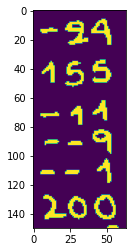

In [40]:
cords,crops = bounding_numbers(sec_1)

In [14]:
vals = get_unique_vals(cords)


In [23]:
ref_vec = logic_fill(vals)
row_idx = [i for i, v in enumerate(ref_vec) if v == 1]
print("Rows where model detected ",ref_vec)
print("The following rows contain at least one detected digit",row_idx)

Rows where model detected  [1, 1, 1, 1, 1, 1]
The following rows contain at least one detected digit [0, 1, 2, 3, 4, 5]


In [27]:
t_index,t_crops = extract_vals(vals,cords)

In [29]:
t = extract_final_ids(t_index,t_crops)


[[2, 0, 1], [3], [4], [7], [9, 8, 10], [11, 12]]

In [54]:
batch = create_batch(t,crops)

3

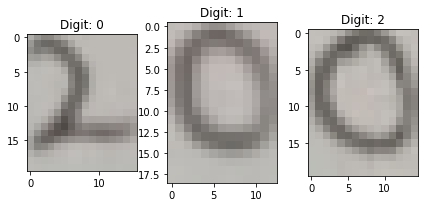

In [89]:
plot_digits(batch,0)




## Digits processing

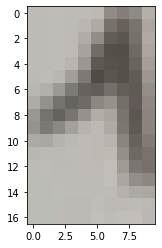

In [144]:
row = 3
img_in = batch[row][0]
plt.imshow(img_in)

In [162]:
## 1 Lets add a border
#pil = Image.fromarray(img_in)
#t = ImageOps.expand(pil,border=4,fill='white')
arr = np.asarray(img_in)
#plt.imshow(arr)
#plt.show()

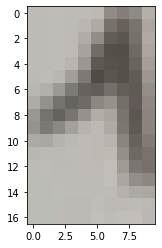

In [163]:
## 1. Primero a escala de grises
gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
plt.imshow(arr)
plt.show()

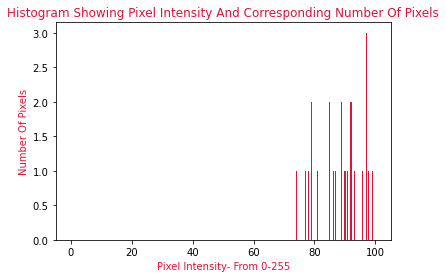

In [160]:
## There is an evident lack of contrast
import matplotlib.pyplot as plt
plt.hist(gray.ravel(), 256, [0,100], color='crimson')
plt.ylabel("Number Of Pixels", color='crimson')
plt.xlabel("Pixel Intensity- From 0-255", color='crimson')
plt.title("Histogram Showing Pixel Intensity And Corresponding Number Of Pixels", color='crimson')
plt.show()

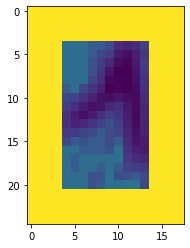

In [155]:
image_en = cv2.equalizeHist(gray)
plt.imshow(image_en)

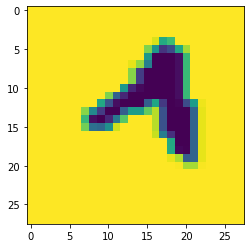

In [157]:
## 2. Apply threshold
_,X_test_th = cv2.threshold(gray,135,255,cv2.THRESH_BINARY)
fix  = cv2.resize(X_test_th, (28,28))
t = np.expand_dims(fix, axis=2)
g = np.expand_dims(t,axis=0)
plt.imshow(fix)


In [106]:
model = load_model("cnn_model\digit_classifier.h5")